LOAD LIBRARIES


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

1. LOAD AND PREPARE DATA

In [33]:

# Load data from GitHub
onet_tasks_url = "https://github.com/WHardyUW/RRcourse2025/raw/main/Data/onet_tasks.csv"
eurostat_url = "https://github.com/WHardyUW/RRcourse2025/raw/main/Data/Eurostat_employment_isco.xlsx"

# Load and process task data
task_data = pd.read_csv(onet_tasks_url)
task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)
aggdata = task_data.groupby(["isco08_1dig"]).mean().drop(columns=["isco08"])

# Load and process employment data
isco_sheets = {f"isco{i}": pd.read_excel(eurostat_url, sheet_name=f"ISCO{i}")
              for i in range(1, 10)}

# Add ISCO category labels
for i, df in isco_sheets.items():
    df['ISCO'] = int(i.replace("isco", ""))

# Merge all employment data
all_data = pd.concat(isco_sheets.values(), ignore_index=True)

# Calculate shares for each country
COUNTRIES = ["Belgium", "Spain", "Poland"]
for country in COUNTRIES:
    total = sum(df[country] for df in isco_sheets.values())
    all_data[f"total_{country}"] = pd.concat([total]*9, ignore_index=True)
    all_data[f"share_{country}"] = all_data[country] / all_data[f"total_{country}"]

# Merge with task data
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')


2. IMPROVED FUNCTIONS

In [34]:
def standardize_task(data, task_col, country):
    """Standardize task values by country weights"""
    weights = data[f"share_{country}"]
    mean = np.average(data[task_col], weights=weights)
    std = np.sqrt(np.average((data[task_col]-mean)**2, weights=weights))
    return (data[task_col] - mean) / std

def calculate_nrca_index(data, country, tasks):
    """Calculate NRCA index for a country"""
    std_cols = [f"std_{country}_{task}" for task in tasks]
    index = data[std_cols].sum(axis=1)

    # Standardize the index
    weights = data[f"share_{country}"]
    mean = np.average(index, weights=weights)
    std = np.sqrt(np.average((index-mean)**2, weights=weights))
    return (index - mean) / std

3. CONFIGURATION

In [35]:
TASKS = {
    "NRCA": ["t_4A2a4", "t_4A2b2", "t_4A4a1"],
    "Routine": ["t_4A3a3", "t_4C2d1i", "t_4C3d3"]
}



4. PROCESSING PIPELINE


In [36]:

# Standardize all tasks
for country in COUNTRIES:
    for task in TASKS["NRCA"]:
        combined[f"std_{country}_{task}"] = standardize_task(combined, task, country)

# Calculate indices
for country in COUNTRIES:
    combined[f"{country}_NRCA"] = calculate_nrca_index(combined, country, TASKS["NRCA"])
    combined[f"multip_{country}_NRCA"] = combined[f"{country}_NRCA"] * combined[f"share_{country}"]


5. VISUALIZATION

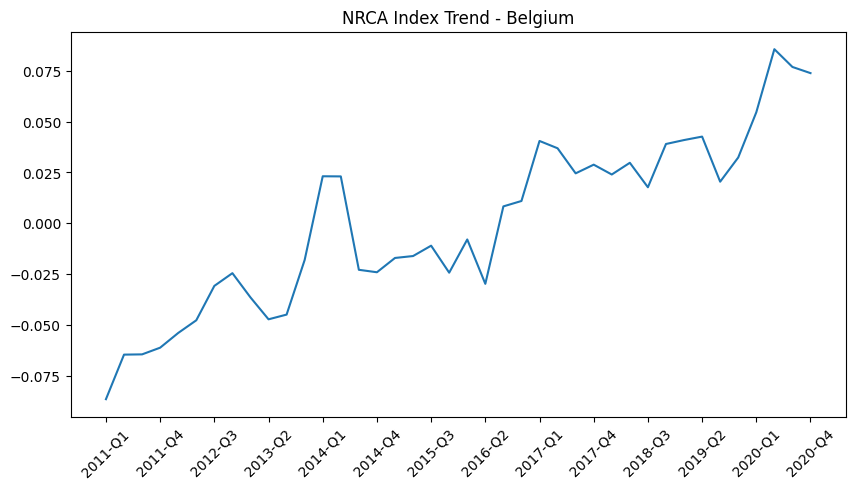

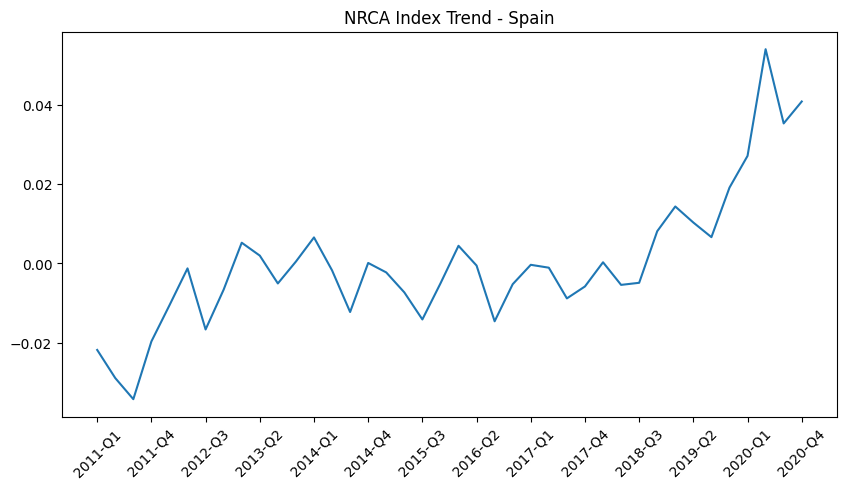

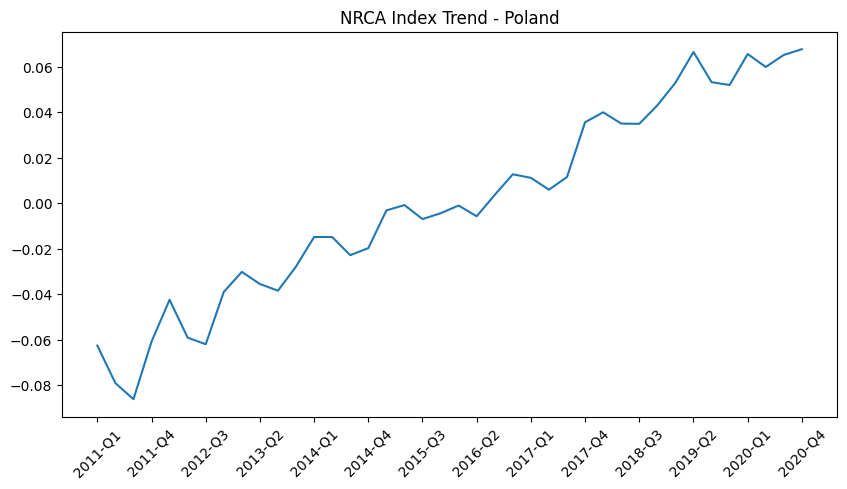

In [37]:

def plot_country_trend(data, country, task_type="NRCA"):
    agg = data.groupby("TIME")[f"multip_{country}_{task_type}"].sum().reset_index()

    plt.figure(figsize=(10,5))
    plt.plot(agg["TIME"], agg[f"multip_{country}_{task_type}"])
    plt.title(f"{task_type} Index Trend - {country}")
    plt.xticks(agg["TIME"][::3], rotation=45)
    plt.show()

for country in COUNTRIES:
    plot_country_trend(combined, country)